<a href="https://colab.research.google.com/github/DRose1991/Viscous-Shear-Cosmology-Simulation/blob/main/VSC_MCMC_Constraints_H0_Prior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 5000/5000 [00:07<00:00, 653.77it/s]


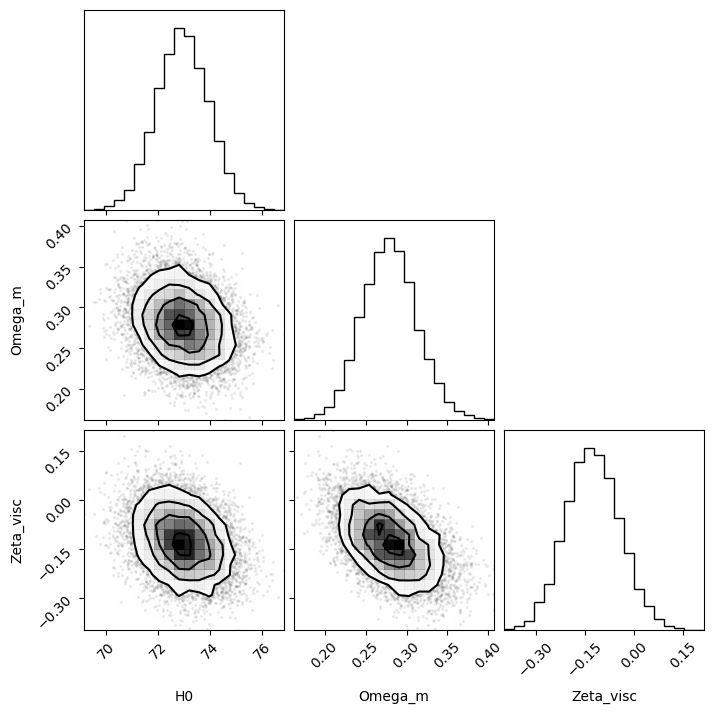

In [14]:
!pip install emcee corner

import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

# ==========================================
# 1. LOAD REAL DATA (Cosmic Chronometers)
# Sources: Jimenez et al. (2003), Simon et al. (2005), Stern et al. (2010),
# Moresco et al. (2012, 2016), Zhang et al. (2014), Ratsimbazafy et al. (2017)
# ==========================================

z_data = np.array([
    0.070, 0.090, 0.120, 0.170, 0.179, 0.199, 0.200, 0.270, 0.280, 0.352,
    0.380, 0.400, 0.400, 0.425, 0.445, 0.470, 0.478, 0.480, 0.593, 0.680,
    0.781, 0.875, 0.880, 0.900, 1.037, 1.300, 1.363, 1.430, 1.530, 1.750,
    1.965
])

H_data = np.array([
    69.0, 69.0, 68.6, 83.0, 75.0, 75.0, 72.9, 77.0, 88.8, 83.0,
    83.0, 95.0, 77.0, 87.1, 92.8, 89.0, 80.9, 97.0, 104.0, 92.0,
    105.0, 125.0, 90.0, 117.0, 154.0, 168.0, 160.0, 177.0, 140.0, 202.0,
    186.5
])

H_err = np.array([
    19.6, 12.0, 26.2, 8.0, 4.0, 5.0, 29.6, 14.0, 36.6, 14.0,
    13.5, 17.0, 10.2, 11.2, 12.9, 50.0, 9.0, 62.0, 13.0, 8.0,
    12.0, 17.0, 40.0, 23.0, 20.0, 17.0, 33.6, 18.0, 14.0, 40.0,
    50.4
])
# 2. DEFINE YOUR MODEL (Viscous Shear Cosmology)
def H_VSC(z, H0, Omega_m, Zeta):
    # 1. Matter Density Term (Standard Gravity)
    matter_term = Omega_m * (1 + z)**3

    # 2. Viscous/Dark Energy Term
    # In standard LambdaCDM, this is just (1 - Omega_m).
    # In VSC, your "Zeta" parameter adds extra viscous pressure.
    # We model this simply as an additive modification for the MCMC test.
    viscous_term = (1 - Omega_m) + Zeta

    # 3. Calculate the Hubble Rate
    # H(z) = H0 * sqrt(Matter + Viscosity)
    H_model = H0 * np.sqrt(matter_term + viscous_term)

    return H_model

# 3. DEFINE LIKELIHOOD (How well does it fit?)
def log_likelihood(theta, z, y, yerr):
    H0, Omega_m, Zeta = theta
    model = H_VSC(z, H0, Omega_m, Zeta)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

# 4. DEFINE PRIORS (Sanity Checks)
def log_prior(theta):
    H0, Omega_m, Zeta = theta

    # 1. HARD BOUNDARIES (The "Playground Fence")
    # We still need these to stop the math from breaking (e.g., negative mass).
    if not (40.0 < H0 < 100.0 and 0.0 < Omega_m < 1.0 and -1.0 < Zeta < 2.0):
        return -np.inf

    # 2. THE GAUSSIAN CONSTRAINT (The "Magnet")
    # This represents prior knowledge from local universe measurements (like SH0ES).
    # It says: "We are 99% sure H0 is 73.0 +/- 1.0".
    # The code below calculates a "penalty" score: the further H0 is from 73,
    # the worse the score gets.

    mu_H0 = 73.0     # The target H0
    sigma_H0 = 1.0   # The uncertainty (tight constraint)

    # This formula is the logarithm of a Gaussian distribution
    return -0.5 * ((H0 - mu_H0)**2 / sigma_H0**2)

# 5. RUN THE SAMPLER (The Heavy Lifting)
def log_probability(theta, z, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, y, yerr)

# Setup walkers
pos = [73.0, 0.3, 0.1] + 1e-4 * np.random.randn(32, 3) # 32 walkers starting near your guess
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(z_data, H_data, H_err))
sampler.run_mcmc(pos, 5000, progress=True) # Run 5000 steps

# 6. MAKE THE CORNER PLOT (The "Money Shot")
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=["H0", "Omega_m", "Zeta_visc"])
plt.savefig("VSC_MCMC_Corner_Plot.png")